In [ ]:
!pip install -q -U 'tensorflow-text==2.8.*'

     |████████████████████████████████| 4.9 MB 21.3 MB/s 
     |████████████████████████████████| 498.0 MB 13 kB/s 
     |████████████████████████████████| 462 kB 75.1 MB/s 
     |████████████████████████████████| 5.8 MB 63.8 MB/s 
     |████████████████████████████████| 1.4 MB 62.1 MB/s 


In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.4 MB 32.7 MB/s 
     |████████████████████████████████| 352 kB 72.6 MB/s 
     |████████████████████████████████| 1.3 MB 66.2 MB/s 
     |████████████████████████████████| 2.3 MB 64.5 MB/s 
     |████████████████████████████████| 662 kB 74.1 MB/s 
     |████████████████████████████████| 118 kB 10.2 MB/s 
     |████████████████████████████████| 1.1 MB 65.2 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 588.3 MB 22 kB/s 
     |████████████████████████████████| 38.2 MB 1.3 MB/s 
     |████████████████████████████████| 5.8 MB 51.6 MB/s 
     |████████████████████████████████| 238 kB 82.6 MB/s 
     |████████████████████████████████| 439 kB 75.0 MB/s 
     |████████████████████████████████| 1.7 MB 68.9 MB/s 
     |████████████████████████████████| 6.0 MB 62.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import time
import unicodedata
import datetime
import pathlib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers

import tensorflow_hub as hub
import tensorflow_models as tfm

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [ ]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

## Variabili Globali

In [ ]:
# PARAMETRI GLOBALI
root_folder = 'drive/MyDrive/BERT/'

# DATI
data_folder_name = 'data'
train_filename = 'ita.txt'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit/transformer_no_bert_v4'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))) 

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights/transformer_nobert_v4'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))
checkpoint_path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp.ckpt'))

## Iperparametri Modello

In [ ]:
# Colonne Dataset
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'

# parametri per il modello
NUM_SAMPLES = 400000 
TRAIN = 18016
VALIDATION = 6016
TEST = 100

MAX_VOCAB_SIZE = 20000 # portato da 20.0000 a 200.000
EMBEDDING_DIM = 64  # --> 256  Densa non lineare relu --> 64  Densa non lineare relu (oppure Conv1D kernel=1)
HIDDEN_DIM = 1024 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
BUFFER_SIZE = 2000
EPOCHS_ADAM = 50
EPOCHS_SGD = 20
MAX_SEQ_LENGTH = 64

NUM_LAYERS = 1 # Numero di layer di Encoder e Decoder del Transformer
NUM_HEADS = 8 # Numero di meccanismi di multi-head attention
FF_DIM = 16 # Numero di celle dei Layer Feed Forward
DROPUOT = 0.5

# Ottimizzatore Adam
LEARNING_RATE_ADAM = 1e-4
BETA_1 = 0.66
BETA_2 = 0.999

# Ottimizzatore SGD
LEARNING_RATE_SGD = 1e-4

# IMPOSTO IL DEBUG A TRUE 
debug = True
training = True

## Dataset

In [ ]:
# Caricamento dataset: frasi in inglese, frasi in italiano
df = pd.read_csv(
    train_filenamepath,
    sep="\t",
    header=None,
    names=[INPUT_COLUMN, TARGET_COLUMN],
    usecols=[0,1],
    nrows=NUM_SAMPLES
)

df = df[-(TRAIN+VALIDATION+TEST):].reset_index(drop=True)

# Mischio il dataset in modo che sia più uniforme tra train e test
df = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)

print(df.iloc[-4:], '\n')

# Preprocessing dei dati di Input
input_data = df[INPUT_COLUMN].tolist()

# Preprocessing dei dati Target con aggiunta del token di fine frase
target_data = df[TARGET_COLUMN].tolist()


train_input_data = input_data[:TRAIN]
train_target_data = target_data[:TRAIN]

validation_input_data = input_data[TRAIN:TRAIN+VALIDATION]
validation_target_data = target_data[TRAIN:TRAIN+VALIDATION]

test_input_data = input_data[TRAIN+VALIDATION:]
test_target_data = target_data[TRAIN+VALIDATION:]

print('-----------TRAIN SET--------------')
print(train_input_data[-4:])
print(train_target_data[-4:])
print('-----------VALIDATION SET---------------')
print(validation_input_data[-4:])
print(validation_target_data[-4:])
print('-----------TEST SET---------------')
print(test_input_data[-4:])
print(test_target_data[-4:])

                                                   input  \
24128  I like to take a hot bath every night before bed.   
24129  The gate is wide enough for the car to go thro...   
24130  As a child, I liked baseball better than footb...   
24131      I am looking for a book about medieval Spain.   

                                                  target  
24128  Mi piace fare un bagno caldo ogni notte prima ...  
24129  Il cancello è sufficientemente largo perché ci...  
24130  Da bambina, mi piaceva di più il baseball del ...  
24131      Sto cercando un libro sulla Spagna medievale.   

-----------TRAIN SET--------------
["What's your favorite non-caffeinated drink?", "What's the average age of students in this class?", 'He is a scientist who is respected by everybody.', 'Have you ever dug a hole as deep as this one?']
['Qual è la tua bevanda senza caffeina preferita?', "Qual è l'età media degli studenti in questa classe?", 'Lui è uno scienziato rispettato da tutti.', 'Ha mai scava

### Analisi Dati

In [ ]:
print(f'Esempi nel Dataset di Train                            : {len(train_input_data)}')
print(f'Frase più corta in inglese nel Dataset di Train        : {min(train_input_data, key = len)}')
print(f'Frase più corta in italiano nel Dataset di Train       : {min(train_target_data, key = len)}')
print(f'Frase più lunga in inglese nel Dataset di Train        : {max(train_input_data, key = len)}')
print(f'Frase più lunga in italiano nel Dataset di Train       : {max(train_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Validation                       : {len(validation_input_data)}')
print(f'Frase più corta in inglese nel Dataset di Validation   : {min(validation_input_data, key = len)}')
print(f'Frase più corta in italiano nel Dataset di Validation  : {min(validation_target_data, key = len)}')
print(f'Frase più lunga in inglese nel Dataset di Validation   : {max(validation_input_data, key = len)}')
print(f'Frase più lunga in italiano nel Dataset di Validation  : {max(validation_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Test                             : {len(test_input_data)}')
print(f'Frase più corta in inglese nel Dataset di Test         : {min(test_input_data, key = len)}')
print(f'Frase più corta in italiano nel Dataset di Test        : {min(test_target_data, key = len)}')
print(f'Frase più lunga in inglese nel Dataset di Test         : {max(test_input_data, key = len)}')
print(f'Frase più lunga in italiano nel Dataset di Test        : {max(test_target_data, key = len)}')

Esempi nel Dataset di Train                            : 18016
Frase più corta in inglese nel Dataset di Train        : Pass me the salt, please. "Here you are."
Frase più corta in italiano nel Dataset di Train       : Dormiamo da mio zio.
Frase più lunga in inglese nel Dataset di Train        : Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people, and out of the few hundred that there are but a dozen or less whom he knows intimately, and out of the dozen, one or two friends at most, it will easily be seen, when we remember the number of millions who inhabit this world, that probably, since the earth was created, the right man has never yet met the right woman.
Frase più lunga in italiano nel Dataset di Train       : Senza dubbio esiste in questo mondo proprio la donna giusta per ogni uomo da sposare e viceversa; ma se si c

## Tokenizer

Creo il modello di tokenizer creato utilizzzando il set di dati a disposizione

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)

train_en = dataset.map(lambda en, it: en)
train_it = dataset.map(lambda en, it: it)

bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = MAX_VOCAB_SIZE,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [ ]:
en_vocab = bert_vocab.bert_vocab_from_dataset(
    train_en.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
    **bert_vocab_args
)

write_vocab_file(en_vocab_filenamepath, en_vocab)

In [ ]:
it_vocab = bert_vocab.bert_vocab_from_dataset(
    train_it.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
    **bert_vocab_args
)

write_vocab_file(it_vocab_filenamepath, it_vocab)

In [ ]:
en_tokenizer = text.BertTokenizer(en_vocab_filenamepath, **bert_tokenizer_params)
it_tokenizer = text.BertTokenizer(it_vocab_filenamepath, **bert_tokenizer_params)

In [ ]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  x = tf.concat([starts, ragged, ends], axis=1)
  # x = keras.preprocessing.sequence.pad_sequences(x.numpy(), maxlen=MAX_SEQ_LENGTH, padding='post')
  return x

def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

### Creo la Classe Custom Tokenizer

In [ ]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    
    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()
    
  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

In [ ]:
tokenizers = tf.Module()
tokenizers.en = CustomTokenizer(reserved_tokens, en_vocab_filenamepath)
tokenizers.it = CustomTokenizer(reserved_tokens, it_vocab_filenamepath)

### Analisi Dati Tokenizzati

In [ ]:
print(f'Vocabolario Inglese  : {tokenizers.en.get_vocab_size()}')
print(f'Vocabolario Italiano : {tokenizers.it.get_vocab_size()}')

Vocabolario Inglese  : 2432
Vocabolario Italiano : 3006


In [ ]:
print(input_data[-2:])
print(tokenizers.en.tokenize(input_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize(input_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.en.detokenize(tokenizers.en.tokenize(input_data[-2:])))
print('------------------------------------------------------------------')
print(target_data[-2:])
print(tokenizers.it.tokenize(target_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.it.tokenize(target_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.it.detokenize(tokenizers.it.tokenize(target_data[-2:])))

['As a child, I liked baseball better than football.', 'I am looking for a book about medieval Spain.']
<tf.RaggedTensor [[2, 86, 26, 464, 9, 34, 1081, 827, 221, 123, 828, 11, 3],
 [2, 34, 282, 321, 63, 26, 194, 97, 71, 143, 1836, 2431, 318, 1539, 11, 3]]>
[[   2   86   26  464    9   34 1081  827  221  123  828   11    3    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   2   34  282  321   63   26  194   97   71  143 1836 2431  318 1539
    11    3    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
tf.Tensor(
[b'as a child , i liked baseball better than football .'
 b'i am look

In [ ]:
print([min(train_input_data, key = len)])
print(tokenizers.en.tokenize([min(train_input_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize([min(train_input_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.en.detokenize(tokenizers.en.tokenize([min(train_input_data, key = len)])))
print('------------------------------------------------------------------')
print([min(train_target_data, key = len)])
print(tokenizers.en.tokenize([min(train_target_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize([min(train_target_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.en.detokenize(tokenizers.en.tokenize([min(train_target_data, key = len)])))

['Pass me the salt, please. "Here you are."']
<tf.RaggedTensor [[2, 546, 71, 52, 44, 318, 206, 9, 185, 11, 5, 131, 54, 75, 11, 5, 3]]>
[[  2 546  71  52  44 318 206   9 185  11   5 131  54  75  11   5   3   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
tf.Tensor([b'pass me the salt , please . " here you are . "'], shape=(1,), dtype=string)
------------------------------------------------------------------
['Dormiamo da mio zio.']
<tf.RaggedTensor [[2, 67, 361, 453, 625, 453, 308, 29, 262, 38, 616, 308, 51, 616, 308, 11,
  3]]>
[[  2  67 361 453 625 453 308  29 262  38 616 308  51 616 308  11   3   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
tf.Tensor([b'dormiamo da mio zio .'], shape=(1,), dty

In [ ]:
print([max(train_input_data, key = len)])
print(tokenizers.en.tokenize([max(train_input_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize([max(train_input_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.en.detokenize(tokenizers.en.tokenize([max(train_input_data, key = len)])))
print('------------------------------------------------------------------')
print([max(train_target_data, key = len)])
print(tokenizers.en.tokenize([max(train_target_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize([max(train_target_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.en.detokenize(tokenizers.en.tokenize([max(train_target_data, key = len)])))

['Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people, and out of the few hundred that there are but a dozen or less whom he knows intimately, and out of the dozen, one or two friends at most, it will easily be seen, when we remember the number of millions who inhabit this world, that probably, since the earth was created, the right man has never yet met the right woman.']
<tf.RaggedTensor [[2, 1770, 1046, 91, 2171, 70, 56, 66, 235, 41, 892, 2428, 1157, 184, 52,
  265, 693, 63, 201, 924, 277, 53, 1360, 65, 47, 935, 101, 814, 262, 24,
  93, 89, 54, 899, 59, 26, 1303, 348, 104, 52, 1365, 57, 348, 1572, 68,
  132, 26, 408, 668, 121, 9, 65, 125, 57, 52, 408, 668, 59, 91, 75, 93,
  26, 67, 2136, 142, 545, 111, 453, 60, 333, 56, 206, 616, 1842, 184, 9,
  65, 125, 57, 52, 67, 2136, 9, 103, 142, 192, 175, 80, 240, 9, 61, 96,
  146

## Creazione Dataset  Modello
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [ ]:
def prepare_batch(en, it):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int64)
  en = tokenizers.en.tokenize(en) # Output is ragged.
  en = tf.concat([en, zero], 1)
  en = en[:, :MAX_SEQ_LENGTH]     # Trim to MAX_TOKENS.
  en = en.to_tensor()             # Convert to 0-padded dense Tensor

  it = tokenizers.it.tokenize(it)
  it_inputs = it[:, :-1].to_tensor()  # Drop the [END] tokens
  it_labels = it[:, 1:].to_tensor()   # Drop the [START] tokens
  
  it_inputs = tf.concat([it_inputs, zero], 1)
  it_inputs = it_inputs[:, :(MAX_SEQ_LENGTH)]

  it_labels = tf.concat([it_labels, zero], 1)
  it_labels = it_labels[:, :(MAX_SEQ_LENGTH)]

  return (en, it_inputs), it_labels

In [ ]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
# Definizione del dataset
# [from_tensor_slices] permette di recuperare batch
# di esempi dai dataset di riferimento
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_input_data, validation_target_data))

# impostazione del recupero di esempi presi in maniera
# casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
train_dataset = make_batches(train_dataset)
validation_dataset = make_batches(validation_dataset)

In [ ]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (en_input, it_input), it_target in train_dataset.take(1):
  print(f'Shape en input           : {en_input.shape}')
  print(f'Example en input         : {en_input[0]}')  
  print('-------------------------------------------------------')
  print(f'Shape it input           : {it_input.shape}')
  print(f'Example it input         : {it_input[0]}')  
  print(f'Shape it input           : {it_target.shape}')
  print(f'Example it target        : {it_target[0]}')  

Shape en input           : (32, 64)
Example en input         : [   2   60  268   61  323   53  171  425 1004   56 1409   11    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
-------------------------------------------------------
Shape it input           : (32, 64)
Example it input         : [   2  911  287 1554  356   62  196  772  891   11    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Shape it input           : (32, 64)
Example it target        : [ 911  287 1554  356   62  196  772  891   11    3    0    0    0    0
    0    0    0    0    0    0  

## Token and Position Embedding

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x, debug=False):
    x = keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [ ]:
token_position_en = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.en.get_vocab_size(), EMBEDDING_DIM)
token_position_it = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.it.get_vocab_size(), EMBEDDING_DIM)

inputs_encoder = token_position_en(en_input, debug)
inputs_decoder = token_position_it(it_input, debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************
********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************


## Encoder

Implmentazione di un blocco di EncoderTransformer tramite estensione della classe Layer di Keras

In [ ]:
class Encoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='ENC'):
    super(Encoder, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, training=False, debug=False):
    attn_output = self.att(query=inputs,
                           value=inputs, 
                           key=inputs)
    
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(inputs + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)

    output = self.layernorm2(out1 + ffn_output)

    if debug:
      print('********************* DEBUG ENCODER *********************')
      print(f'Shape Input Layer Encoder       : {inputs.shape}')
      print(f'Shape Output Layer Encoder      : {output.shape}')
      print('*********************************************************')

    return output

In [ ]:
encoder = Encoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_encoder = encoder(inputs=inputs_encoder,
                          training=training, 
                          debug=debug)

********************* DEBUG ENCODER *********************
Shape Input Layer Encoder       : (32, 64, 64)
Shape Output Layer Encoder      : (32, 64, 64)
*********************************************************


## Decoder

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

In [ ]:
class Decoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DEC'):
    super(Decoder, self).__init__()
    self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.layernorm3 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, encoder_output, training=False, debug=False):
    attn_output1 = self.att1(query=inputs,
                             value=inputs, 
                             key=inputs, 
                             use_causal_mask=True)
    
    attn_output1 = self.dropout1(attn_output1)
    out1 = self.layernorm1(inputs + attn_output1)

    attn_output2 = self.att2(key=encoder_output, 
                             value=encoder_output, 
                             query=out1)
    
    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [ ]:
decoder = Decoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_decoder = decoder(inputs=inputs_decoder, 
                          encoder_output=outputs_encoder,  
                          training=training,
                          debug=debug)

******************* DEBUG DECODER ***********************
Input Shape                       : (32, 64, 64)
Shape Outputs Decoder             : (32, 64, 64)
*********************************************************


## Transformer

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras

In [ ]:
class TransformerBlock(keras.Model):
  def __init__(self, 
               num_layers, 
               embed_dim, 
               num_heads, 
               ff_dim, 
               max_len,
               input_vocab_size,
               target_vocab_size,
               rate=0.5):
    
    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers

    self.token_pos_enc = TokenAndPositionEmbedding(max_len, input_vocab_size, embed_dim)
    self.token_pos_dec = TokenAndPositionEmbedding(max_len, target_vocab_size, embed_dim)

    self.encoder = [Encoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
    self.decoder = [Decoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

    self.dropout = layers.Dropout(rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training=False, debug=False):
    inputs_encoder, inputs_decoder  = inputs

    inputs_encoder = self.token_pos_enc(inputs_encoder, debug)
    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_encoder       : {inputs_encoder.shape}')
      print(f'inputs_decoder       : {inputs_decoder.shape}')      

    encoder_output = inputs_encoder
    transformer_output = inputs_decoder

    for i in range(self.num_layers):
      encoder_output = self.encoder[i](inputs=encoder_output, 
                                       training=training, 
                                       debug=debug) 
      
    for i in range(self.num_layers):
      transformer_output = self.decoder[i](inputs=transformer_output, 
                                           encoder_output=encoder_output, 
                                           training=training,
                                           debug=debug)

    transformer_output = self.dropout(transformer_output)
    logits = self.final_layer(transformer_output)

    if debug:
      print(f'Output Shape       : {logits.shape}')
      print(f'Output Transformer : {logits[0, :1, :12]}')    
      print(f'---------------------------------------------------------')

    return logits

In [ ]:
transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.en.get_vocab_size(),
                               tokenizers.it.get_vocab_size(),
                               DROPUOT)

transformer_output = transformer((en_input, it_input), 
                                 training=training,
                                 debug=debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************
********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************
---------------- DEBUG TRANSFORMER BLOCK ----------------
inputs_encoder       : (32, 64, 64)
inputs_decoder       : (32, 64, 64)
********************* DEBUG ENCODER *********************
Shape Input Layer Encoder       : (32, 64, 64)
Shape Output Layer Encoder      : (32, 64, 64)
*********************************************************
******************* DEBUG DECODER ***********************
Input Shape                       : (32, 64, 64)
Shape Out

In [ ]:
transformer.summary()

Model: "transformer_block_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 159744    
 g_6 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 token_and_position_embeddin  multiple                 196480    
 g_7 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 ENC (Encoder)               multiple                  135056    
                                                                 
 DEC (Decoder)               multiple                  267856    
                                                                 
 dropout_30 (Dropout)        multiple          

## Addestramento Modello con Ottimizzatore ADAM

### Compilazione

In [ ]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ADAM, 
                                       beta_1=BETA_1, 
                                       beta_2=BETA_2),
    metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

### Addestramento

In [ ]:
start = datetime.datetime.now()
history = transformer.fit(train_dataset,
                          epochs=EPOCHS_ADAM,
                          shuffle=True,
                          validation_data=validation_dataset,
                          callbacks=[tensorboard_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 1/50
563/563 [==============================] - 190s 338ms/step - loss: 4.3568 - sparse_categorical_accuracy: 0.7415 - val_loss: 1.8686 - val_sparse_categorical_accuracy: 0.7693
Epoch 2/50
563/563 [==============================] - 190s 337ms/step - loss: 1.6125 - sparse_categorical_accuracy: 0.7881 - val_loss: 1.3576 - val_sparse_categorical_accuracy: 0.8049
Epoch 3/50
563/563 [==============================] - 196s 348ms/step - loss: 1.3514 - sparse_categorical_accuracy: 0.8067 - val_loss: 1.2488 - val_sparse_categorical_accuracy: 0.8148
Epoch 4/50
563/563 [==============================] - 192s 341ms/step - loss: 1.2552 - sparse_categorical_accuracy: 0.8140 - val_loss: 1.1815 - val_sparse_categorical_accuracy: 0.8191
Epoch 5/50
563/563 [==============================] - 204s 363ms/step - loss: 1.1908 - sparse_categorical_accuracy: 0.8185 - val_loss: 1.1283 - val_sparse_categorical_accuracy: 0.8239
Epoch 6/50
563/563 [==============================] - 204s 362ms/step - loss: 1.

### Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

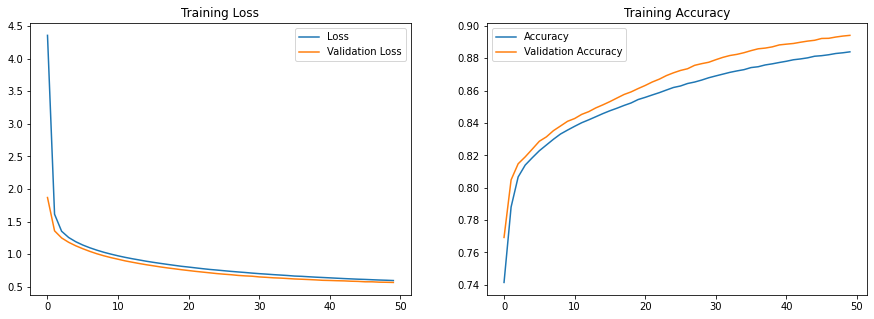

In [ ]:
# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(history.history['loss'], label='Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(history.history['sparse_categorical_accuracy'], label='Accuracy')
ax2.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

### Addestramento 2

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
history = transformer.fit(train_dataset,
                          epochs=EPOCHS_ADAM+EPOCHS_ADAM,
                          initial_epoch=EPOCHS_ADAM,
                          shuffle=True,
                          validation_data=validation_dataset,
                          callbacks=[tensorboard_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 51/100
563/563 [==============================] - 215s 380ms/step - loss: 0.8467 - sparse_categorical_accuracy: 0.8672 - val_loss: 0.6512 - val_sparse_categorical_accuracy: 0.8895
Epoch 52/100
563/563 [==============================] - 188s 333ms/step - loss: 0.7773 - sparse_categorical_accuracy: 0.8706 - val_loss: 0.6113 - val_sparse_categorical_accuracy: 0.8914
Epoch 53/100
563/563 [==============================] - 187s 332ms/step - loss: 0.7418 - sparse_categorical_accuracy: 0.8727 - val_loss: 0.5865 - val_sparse_categorical_accuracy: 0.8927
Epoch 54/100
563/563 [==============================] - 205s 364ms/step - loss: 0.7176 - sparse_categorical_accuracy: 0.8743 - val_loss: 0.5681 - val_sparse_categorical_accuracy: 0.8947
Epoch 55/100
563/563 [==============================] - 205s 364ms/step - loss: 0.6985 - sparse_categorical_accuracy: 0.8757 - val_loss: 0.5588 - val_sparse_categorical_accuracy: 0.8952
Epoch 56/100
563/563 [==============================] - 205s 364ms/ste

### Addestramento 3

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
history = transformer.fit(train_dataset,
                          epochs=EPOCHS_ADAM+EPOCHS_ADAM+EPOCHS_ADAM,
                          initial_epoch=EPOCHS_ADAM+EPOCHS_ADAM,
                          shuffle=True,
                          validation_data=validation_dataset,
                          callbacks=[tensorboard_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 101/150
563/563 [==============================] - 184s 325ms/step - loss: 0.8244 - sparse_categorical_accuracy: 0.8741 - val_loss: 0.6230 - val_sparse_categorical_accuracy: 0.8973
Epoch 102/150
563/563 [==============================] - 200s 355ms/step - loss: 0.7405 - sparse_categorical_accuracy: 0.8784 - val_loss: 0.5719 - val_sparse_categorical_accuracy: 0.9004
Epoch 103/150
563/563 [==============================] - 183s 326ms/step - loss: 0.6985 - sparse_categorical_accuracy: 0.8806 - val_loss: 0.5408 - val_sparse_categorical_accuracy: 0.9023
Epoch 104/150
563/563 [==============================] - 184s 326ms/step - loss: 0.6695 - sparse_categorical_accuracy: 0.8825 - val_loss: 0.5234 - val_sparse_categorical_accuracy: 0.9037
Epoch 105/150
563/563 [==============================] - 180s 320ms/step - loss: 0.6472 - sparse_categorical_accuracy: 0.8844 - val_loss: 0.5074 - val_sparse_categorical_accuracy: 0.9048
Epoch 106/150
563/563 [==============================] - 181s 322

## Addestramento Modello con Ottimizzatore SGD

### Compilazione

In [ ]:
transformer.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE_SGD),
                    metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

### Addestramento

In [ ]:
start = datetime.datetime.now()
history = transformer.fit(train_dataset,
                          epochs=EPOCHS_ADAM+EPOCHS_SGD,
                          initial_epoch=EPOCHS_ADAM,
                          shuffle=True,
                          validation_data=validation_dataset,
                          callbacks=[tensorboard_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

### Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

In [ ]:
# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(history.history['loss'], label='Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(history.history['sparse_categorical_accuracy'], label='Accuracy')
ax2.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

## Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
class Translate:
  def __init__(self, transformer_block, tokenizers):
    self.transformer = transformer_block
    self.tokenizers = tokenizers

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = input_data[np.random.choice(len(input_data))]
      print(input_text)

    # print(input_text)
    inputs_encoder = self.tokenizers.en.tokenize(input_text).to_tensor()
    inputs_encoder = keras.preprocessing.sequence.pad_sequences(inputs_encoder, maxlen=max_length, padding='post')

    # print(inputs_encoder)
    
    start_end = self.tokenizers.it.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int64, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, start)     

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())

      transformer_output = transformer([inputs_encoder, output], 
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (K.argmax(transformer_output, axis=-1)).numpy()
    
      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])

      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.it.detokenize(output)[0]  

    tokens = tokenizers.it.lookup(output)[0]

    return text, tokens

In [ ]:
test_sequences = [test_input_data[41], test_input_data[30], test_input_data[10], 
                  test_input_data[57], test_input_data[82], test_input_data[15], 
                  test_input_data[4], test_input_data[42]]

translate = Translate(transformer_block=transformer,
                      tokenizers=tokenizers)

for test_sequence in test_sequences:
  text, token = translate.predict(tf.constant([test_sequence]), MAX_SEQ_LENGTH)

  print(f'{"Input:":15s}: {test_sequence}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  print('---------------------------------------------')

print(test_target_data[41])
print(test_target_data[30])
print(test_target_data[10])
print(test_target_data[57])
print(test_target_data[82])
print(test_target_data[15])
print(test_target_data[4])
print(test_target_data[42])

Input:         : They seemed to be discussing a matter of great importance.
Prediction     : sembrava che non disccccunicato di un grande importate .
---------------------------------------------
Input:         : We'd really like to help you, but our hands are tied.
Prediction     : noi abbiamo davvero a me piacerebbe aiutare , ma la nostra mani le mani i nostri mani .
---------------------------------------------
Input:         : I presume you are aware of the difficulties.
Prediction     : mi prespiescrivere alla problemi di problemi .
---------------------------------------------
Input:         : I said, "Could you please turn your television down?"
Prediction     : ho detto : " potreste spegnere il suo televisore , per favore ? "
---------------------------------------------
Input:         : Tom digitized an old family photo and emailed it to his mother.
Prediction     : tom ha disffferuanziate e - mail le foto di sua madre e - mail le sue foto di tom .
----------------------------

## Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
log_dir

In [ ]:
%tensorboard --logdir drive/MyDrive/BERT/logs/fit/20221026-134720